In [1]:
#import stuff we'll need

import fnal_column_analysis_tools
from fnal_column_analysis_tools.lookup_tools import extractor,evaluator
from fnal_column_analysis_tools.analysis_objects import JaggedCandidateArray
from fnal_column_analysis_tools.striped import PhysicalColumnGroup,ColumnGroup,jaggedFromColumnGroup

import numpy as np
import uproot

In [2]:
#plot our monte-carlo with weights
from histbook import Hist, beside, groupby, below
from histbook import bin as hbin

#make and fill a histogram of the masses
jetMass = Hist(hbin("m_J", 150,50,200))#, weight="weight")
jetDeepDoubleB = Hist(hbin("deepDoubleB",50,0,1))
jetTau21 = Hist(hbin("tau21",50,0,1))
jetTau32 = Hist(hbin("tau32",50,0,1))

In [3]:
filestr = "/Users/lagray/coffea/bacon_prod/WJetsToQQ_HT400to600_qc19_3j_TuneCP5_13TeV/*.root"

ak8columns = {'pt':'AK8Puppi.pt','eta':'AK8Puppi.eta','phi':'AK8Puppi.phi','mass':'AK8Puppi.mass',
              'deepcsvb':'AK8Puppi.deepcsvbb','msd':'AddAK8Puppi.mass_sd0','deepdoubleb':'AddAK8Puppi.deepdoubleb',
              'deepdoubleb_nomasssculptpen':'AddAK8Puppi.deepdoubleb_nomasssculptpen','tau1':'AddAK8Puppi.tau1',
              'tau2':'AddAK8Puppi.tau2','tau3':'AddAK8Puppi.tau3','e3_v2_sdb1':'AddAK8Puppi.e3_v2_sdb1',
              'e2_sdb1':'AddAK8Puppi.e2_sdb1'}

ak4columns = {'pt':'AK4Puppi.pt','eta':'AK4Puppi.eta','phi':'AK4Puppi.phi','mass':'AK4Puppi.mass',
              'qgid':'AK4Puppi.qgid','csv':'AK4Puppi.csv'}

all_columns = [ak8columns,ak4columns]

columns = []
for cols in all_columns: columns.extend(list(cols.values()))

for arrays in uproot.iterate(filestr,'Events',columns,entrysteps=20000):
    ak4puppijet = JaggedCandidateArray.candidatesfromcounts(arrays[ak4columns['pt']].counts,
                                                            **{key:arrays[val].content for key,val in ak4columns.items()})

    ak8puppijet = JaggedCandidateArray.candidatesfromcounts(arrays[ak8columns['pt']].counts,
                                                            **{key:arrays[val].content for key,val in ak8columns.items()})
    ak8puppijet.add_attributes(tau21=ak8puppijet.tau2/(ak8puppijet.tau1 + 1e-8),
                               tau32=ak8puppijet.tau3/(ak8puppijet.tau2 + 1e-8),
                               N2sdb1=ak8puppijet.e3_v2_sdb1/(ak8puppijet.e2_sdb1**2 + 1e-8))
    
    jetMass.fill(m_J=ak8puppijet[ak8puppijet.counts > 0].msd.max())
    jetDeepDoubleB.fill(deepDoubleB=ak8puppijet[ak8puppijet.counts > 0].deepdoubleb.flatten())
    jetTau21.fill(tau21=ak8puppijet[ak8puppijet.counts > 0].tau21.flatten())
    jetTau32.fill(tau32=ak8puppijet[ak8puppijet.counts > 0].tau32.flatten())

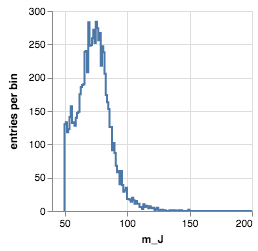

In [4]:
#plot it
from vega import VegaLite as canvas
#import vegascope; canvas = vegascope.LocalCanvas()
jetMass.step("m_J").to(canvas)

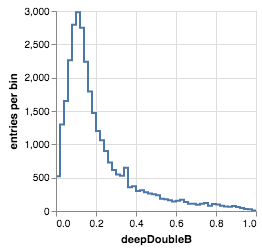

In [5]:
jetDeepDoubleB.step("deepDoubleB").to(canvas)

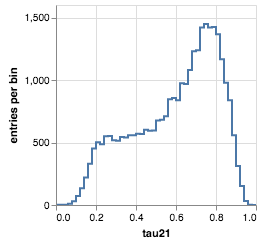

In [6]:
jetTau21.step("tau21").to(canvas)

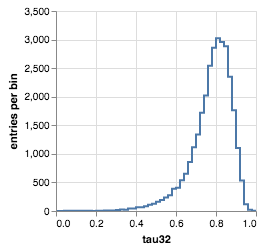

In [7]:
jetTau32.step("tau32").to(canvas)